In [1]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
from functools import partial
import pdb
from scipy import stats
import numpy as np
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as stats

In [3]:
file = '../data/dataset_hpd10_85.csv'
df34 = pd.read_csv(file).infer_objects()
df34.rename(columns={'Unnamed: 0':'Date'},inplace=True)

df2=df34.loc[:,'0.1':'0.85']*1

for hpd in range(10,90,5):
    df2['HPD%s'%(hpd)] = df2[str(hpd/100)]*(hpd/100)
    df2.drop([str(hpd/100)],axis=1,inplace=True)
df2['HPD'] = df2.loc[:,'HPD10':'HPD85'].apply(lambda x:
                                    min(list(filter(lambda s:s!=0,x.to_list())))
                                    if list(filter(lambda s:s!=0,x.to_list()))!=[]
                                    else 0,axis=1)
df34.drop(['0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5','0.55','0.6','0.65','0.7',
          '0.75','0.8','0.85'],axis=1,inplace=True)

df34['virus'] = df2['HPD']
df = df34.copy().replace(0, np.NaN)
virus_mean_monthly = df.groupby(['point','month'],as_index=False)['virus'].mean()
virus_min_monthly = df.groupby(['point','month'],as_index=False)['virus'].min()
virus_max_monthly = df.groupby(['point','month'],as_index=False)['virus'].max()
vmean = virus_mean_monthly.pivot(index='point',values='virus',columns='month')
vmin = virus_min_monthly.pivot(index='point',values='virus',columns='month')
vmax = virus_max_monthly.pivot(index='point',values='virus',columns='month')

FileNotFoundError: [Errno 2] No such file or directory: '../data/2.3.4.4_crosscorr/virus_prob_minHPD.csv'

In [4]:
df.to_csv(r'../data/2.3.4.4_crosscorr/virus_prob_minHPD.csv')

In [3]:
'''file = '../data/dataset_2.3.4.4.csv'
df34 = pd.read_csv(file).infer_objects()
df34.rename(columns={'Unnamed: 0':'Date'},inplace=True)

df2=df34.loc[:,'0.1':'0.95']*1

for hpd in range(10,100,5):
    df2['HPD%s'%(hpd)] = df2[str(hpd/100)]*(hpd/100)
    df2.drop([str(hpd/100)],axis=1,inplace=True)
df2['HPD'] = df2.loc[:,'HPD10':'HPD95'].apply(lambda x:
                                    1-min(list(filter(lambda s:s!=0,x.to_list())))
                                    if list(filter(lambda s:s!=0,x.to_list()))!=[]
                                    else 0,axis=1)
df34.drop(['0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5','0.55','0.6','0.65','0.7',
          '0.75','0.8','0.85','0.9','0.95'],axis=1,inplace=True)

df34['virus'] = df2['HPD']'''

In [4]:
'''df = df34.copy().replace(0, np.NaN)
virus_mean_monthly = df.groupby(['point','month'],as_index=False)['virus'].mean()
virus_min_monthly = df.groupby(['point','month'],as_index=False)['virus'].min()
virus_max_monthly = df.groupby(['point','month'],as_index=False)['virus'].max()
vmean = virus_mean_monthly.pivot(index='point',values='virus',columns='month')
vmin = virus_min_monthly.pivot(index='point',values='virus',columns='month')
vmax = virus_max_monthly.pivot(index='point',values='virus',columns='month')
df.to_csv(r'../data/2.3.4.4_crosscorr/virus_prob_reverseHPD.csv')'''

In [5]:
bird_all_monthly = df34.groupby(['point','month'],as_index=False)['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes'].mean()
#bird_all_monthly.to_csv(r'../data/2.3.4.4_crosscorr/allbirds_prob.csv')

pele = bird_all_monthly.pivot(index='point',columns='month',values='Pelecaniformes')
gru = bird_all_monthly.pivot(index='point',columns='month',values='Gruiformes')
pas = bird_all_monthly.pivot(index='point',columns='month',values='Passeriformes')
suli = bird_all_monthly.pivot(index='point',columns='month',values='Suliformes')
cico = bird_all_monthly.pivot(index='point',columns='month',values='Ciconiiformes')
falc = bird_all_monthly.pivot(index='point',columns='month',values='Falconiformes')
chara = bird_all_monthly.pivot(index='point',columns='month',values='Charadriiformes')
ans = bird_all_monthly.pivot(index='point',columns='month',values='Anseriformes')
acci = bird_all_monthly.pivot(index='point',columns='month',values='Accipitriformes')

<ipython-input-5-c08157416d02>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bird_all_monthly = df34.groupby(['point','month'],as_index=False)['Pelecaniformes','Gruiformes','Passeriformes',


In [6]:
bird_orders = pd.Series([pele,gru,pas,suli,cico,falc,chara,ans,acci],index=['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes'])

In [7]:
virus_prob = vmean.copy().reset_index(drop=True)
virus_prob_shuf = virus_prob.sample(frac=1).reset_index(drop=True)

virus_prob_shuf1 = virus_prob.sample(frac=1, axis=1)
virus_prob_shuf1.columns = range(virus_prob_shuf1.columns.size)

virus_prob_shuf2 = virus_prob.sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)

In [8]:
'''Pearson correlation between bird emergence prob at 1000 locations in a month and 
its viral emergence probability in the same month or a different month'''
crr = pd.DataFrame(np.arange(108).reshape(9, 12), index=['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes'],columns=virus_prob.columns)
crr_shuf = crr.copy()
crr_shuf2 = crr.copy()

for i in bird_orders.index:
    x = bird_orders.loc[i]
    x1 = x.reset_index()
    
    crr.loc[i,:] = virus_prob.corrwith(x1)
    crr_shuf.loc[i,:] = virus_prob_shuf.corrwith(x1)

In [9]:
crr = list()
p = list()

for v_month in range(12):
    crr_tmp = pd.DataFrame(np.arange(108).reshape(9, 12), index=['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes'],columns=virus_prob.columns)
    p_tmp = pd.DataFrame(np.arange(108).reshape(9, 12), index=['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes'],columns=virus_prob.columns)
    for i in bird_orders.index:
        x = bird_orders.loc[i]
        for b_month in range(1,13):
            crr_tmp.loc[i,b_month],p_tmp.loc[i,b_month] = stats.spearmanr(virus_prob.iloc[:,v_month].to_numpy(),
                                                     x.loc[:,b_month].to_numpy(),nan_policy='omit')
            
    crr.append(crr_tmp)
    p.append(p_tmp)

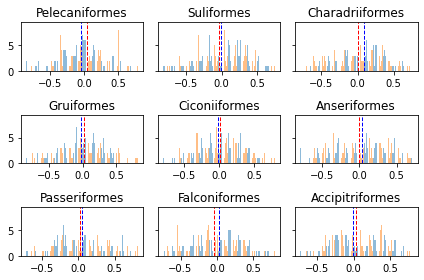

In [14]:
'''1. Cross-correlation of virus probablity at Location A and bird probability of each bird order at Location A-1'''
'''2. Compare the distribution plot and the mean value'''
fig, axs = plt.subplots(3,3,sharey=True, tight_layout=True)
r=0
c=0
for i in bird_orders.index:
    x = bird_orders.loc[i]
    crr_m = virus_prob.copy()
    crr_m_rand = virus_prob.copy()
    
    for point in range(len(x)):
        crr_m.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob.iloc[point,:], x.iloc[point,:], adjusted=False, fft=False)
        crr_m_rand.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob_shuf.iloc[point,:], x.iloc[point,:], adjusted=False, fft=False)
        
    crr_m.to_csv(r'../data/2.3.4.4_crosscorr/Monthly2_crr_%s.csv'%i)
    m = pd.read_csv(r'../data/2.3.4.4_crosscorr/Monthly2_crr_%s.csv'%i)
    crr_m_rand.to_csv(r'../data/2.3.4.4_crosscorr/Shuf_crr_%s.csv'%i)
    m_rand = pd.read_csv(r'../data/2.3.4.4_crosscorr/Shuf_crr_%s.csv'%i)
    
    axs[r,c].hist([m.iloc[:,3],m_rand.iloc[:,3]],bins=100,alpha=0.5)
    axs[r,c].axvline(m_rand.iloc[:,3].mean(), color='red', linestyle='dashed', linewidth=1)
    axs[r,c].axvline(m.iloc[:,3].mean(), color='blue', linestyle='dashed', linewidth=1)
    

    axs[r,c].set_title(r'%s'%i)
    
    if r<2:
        r += 1
    elif r==2 and c<2:
        r = 0
        c += 1


In [102]:
for i in bird_orders.index:
    m = pd.read_csv(r'../data/2.3.4.4_crosscorr/Monthly2_crr_%s.csv'%i)
    m_rand = pd.read_csv(r'../data/2.3.4.4_crosscorr/Shuf1_crr_%s.csv'%i)
    #perform two sample t-test with equal variances
    for lag in range(1,12):
        ttest = stats.ttest_ind(a=m.dropna().iloc[:,lag], b=m_rand.dropna().iloc[:,lag], equal_var=True)
        if (ttest.pvalue < 0.05) & (ttest.statistic>0):
            print('lag=',lag-1,i,'Correlation coeficient=',ttest.statistic,'p value=',ttest.pvalue)

lag= 1 Pelecaniformes Correlation coeficient= 3.1077908799159415 p value= 0.0019545629157248653
lag= 2 Pelecaniformes Correlation coeficient= 4.469824744568308 p value= 9.011069959859876e-06
lag= 1 Passeriformes Correlation coeficient= 6.8148024176510456 p value= 1.91201456799833e-11
lag= 2 Passeriformes Correlation coeficient= 8.611529763313511 p value= 4.0776264473570797e-17
lag= 3 Passeriformes Correlation coeficient= 4.5585845431492436 p value= 5.992914338177838e-06
lag= 8 Suliformes Correlation coeficient= 3.011602050733549 p value= 0.0026841908427947788
lag= 9 Suliformes Correlation coeficient= 5.241327534493927 p value= 2.0633763903206617e-07
lag= 10 Suliformes Correlation coeficient= 7.258672588573476 p value= 9.609842822593648e-13
lag= 2 Ciconiiformes Correlation coeficient= 4.7938566015303445 p value= 1.9656431650952265e-06
lag= 3 Ciconiiformes Correlation coeficient= 2.994155357986226 p value= 0.002840639325748412
lag= 0 Falconiformes Correlation coeficient= 2.56543200270804

FileNotFoundError: [Errno 2] No such file or directory: '../data/2.3.4.4_crosscorr/Monthly_crr_Pelecaniformes.csv'

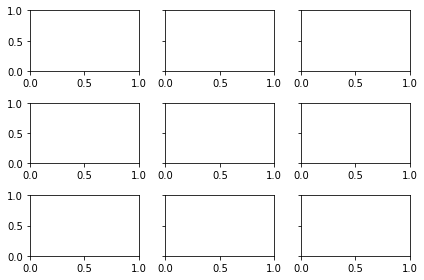

In [12]:
'''Cross-correlation of virus probablity and bird probability of each bird Order'''
virus_prob_rand = virus_prob.copy()

for row in range(0,1000):
    virus_prob_rand.iloc[row,:] = np.random.random(12)

fig, axs = plt.subplots(3,3,sharey=True, tight_layout=True)

r=0
c=0
for i in bird_orders.index:
    x = bird_orders.loc[i]
    #crr_m = virus_prob
    crr_m_rand = virus_prob_rand
    for point in range(len(x)):
        crr_m.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob.iloc[point,:], x.iloc[point,:], adjusted=False)
        crr_m_rand.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob_rand.iloc[point,:], x.iloc[point,:], adjusted=False,fft=False)
    
    #crr_m.to_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    m = pd.read_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    crr_m_rand.to_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    m_rand = pd.read_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    
    axs[r,c].hist([m.iloc[:,1],m_rand.iloc[:,1]],bins=100,alpha=0.5)
    axs[r,c].axvline(m.iloc[:,1].mean(), color='blue', linestyle='dashed', linewidth=1)
    axs[r,c].axvline(m_rand.iloc[:,1].mean(), color='red', linestyle='dashed', linewidth=1)

    axs[r,c].set_title(r'%s'%i)
    
    if r<2:
        r += 1
    elif r==2 and c<2:
        r = 0
        c += 1
    
#fig.savefig(r'../data/2.3.4.4_crosscorr/Crr_0moLag.png',figsize=[12,12],dpi=300)

In [95]:
import scipy.stats as stats
for i in bird_orders.index:
    m = pd.read_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    m_rand = pd.read_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    #perform two sample t-test with equal variances
    for lag in range(1,12):
        ttest = stats.ttest_ind(a=m.dropna().iloc[:,lag], b=m_rand.dropna().iloc[:,lag], equal_var=True)
        if (ttest.pvalue < 0.05) & (ttest.statistic>0):
            print('lag=',lag-1,i,'Correlation coeficient=',ttest.statistic,'p value=',ttest.pvalue)

lag= 1 Pelecaniformes Correlation coeficient= 3.786908701991049 p value= 0.00015907984041526357
lag= 2 Pelecaniformes Correlation coeficient= 6.5871461578604835 p value= 6.357255483629693e-11
lag= 3 Pelecaniformes Correlation coeficient= 5.005692674100014 p value= 6.283078782569038e-07
lag= 4 Pelecaniformes Correlation coeficient= 2.7557922547520493 p value= 0.0059319955674187125
lag= 5 Pelecaniformes Correlation coeficient= 2.4243728138282763 p value= 0.01546251448616602
lag= 9 Gruiformes Correlation coeficient= 4.986048413592349 p value= 6.945028135334725e-07
lag= 10 Gruiformes Correlation coeficient= 5.986749195048839 p value= 2.7258235411973415e-09
lag= 4 Ciconiiformes Correlation coeficient= 2.139596433464114 p value= 0.03256250642278503
lag= 5 Ciconiiformes Correlation coeficient= 3.109420412393225 p value= 0.0019129248539527957
lag= 6 Ciconiiformes Correlation coeficient= 2.6450709852823087 p value= 0.008260158777507881
lag= 0 Falconiformes Correlation coeficient= 3.891154282069

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1104: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))
<ipython-input-9-912808cec4c6>:55: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(r'../data/2.3.4.4_crosscorr/Crr_1moLag.png',figsize=[12,12],dpi=300)


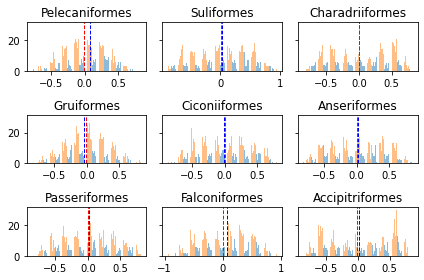

In [9]:
'''Cross-correlation of virus probablity and bird probability of each bird Order'''
crosscrr_mean = pd.DataFrame()
crosscrr_min = pd.DataFrame()
crosscrr_max = pd.DataFrame()

virus_prob_rand = vmean.copy()
virus_prob = vmean.copy()
for row in range(0,1000):
    virus_prob_rand.iloc[row,:] = np.random.random(12)


bird_orders = pd.Series([pele,gru,pas,suli,cico,falc,chara,ans,acci],index=['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes'])

fig, axs = plt.subplots(3,3,sharey=True, tight_layout=True)

r=0
c=0
for i in bird_orders.index:
    x = bird_orders.loc[i]
    crr_m = virus_prob
    crr_m_rand = virus_prob_rand
    for point in range(len(x)):
        crr_m.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob.iloc[point,:], x.iloc[point,:], adjusted=False)
        crr_m_rand.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob_rand.iloc[point,:], x.iloc[point,:], adjusted=False)
    
    crr_m.to_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    m = pd.read_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    crr_m_rand.to_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    m_rand = pd.read_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    
    axs[r,c].hist([m.iloc[:,2],m_rand.iloc[:,2]],bins=100,alpha=0.5)
    axs[r,c].axvline(m.iloc[:,2].mean(), color='blue', linestyle='dashed', linewidth=1)
    axs[r,c].axvline(m_rand.iloc[:,2].mean(), color='red', linestyle='dashed', linewidth=1)

    axs[r,c].set_title(r'%s'%i)
    
    if r<2:
        r += 1
    elif r==2 and c<2:
        r = 0
        c += 1
    
    #mmean = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].mean()
    #mmin = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].min()
    #mmax = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].max()
    #crosscrr_mean = pd.concat([crosscrr_mean,mmean.rename(i)],axis=1)
    #crosscrr_min = pd.concat([crosscrr_min,mmin.rename(i)],axis=1)
    #crosscrr_max = pd.concat([crosscrr_max,mmax.rename(i)],axis=1)
    #crosscrr_mean.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_mean.csv')
    #crosscrr_min.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_min.csv')
    #crosscrr_max.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_max.csv')
    
fig.savefig(r'../data/2.3.4.4_crosscorr/Crr_1moLag.png',figsize=[12,12],dpi=300)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1104: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))
<ipython-input-6-c2ac0d9c6999>:55: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(r'../data/2.3.4.4_crosscorr/Crr_2moLag.png',figsize=[12,12],dpi=300)


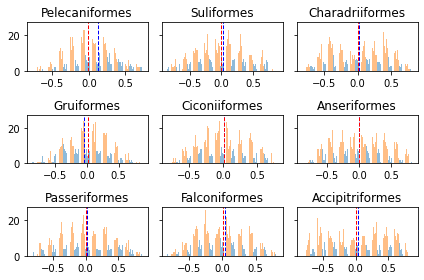

In [6]:
'''Cross-correlation of virus probablity and bird probability of each bird Order'''
crosscrr_mean = pd.DataFrame()
crosscrr_min = pd.DataFrame()
crosscrr_max = pd.DataFrame()

virus_prob_rand = vmean.copy()
virus_prob = vmean.copy()
for row in range(0,1000):
    virus_prob_rand.iloc[row,:] = np.random.random(12)


bird_orders = pd.Series([pele,gru,pas,suli,cico,falc,chara,ans,acci],index=['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes'])

fig, axs = plt.subplots(3,3,sharey=True, tight_layout=True)

r=0
c=0
for i in bird_orders.index:
    x = bird_orders.loc[i]
    crr_m = virus_prob
    crr_m_rand = virus_prob_rand
    for point in range(len(x)):
        crr_m.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob.iloc[point,:], x.iloc[point,:], adjusted=False)
        crr_m_rand.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob_rand.iloc[point,:], x.iloc[point,:], adjusted=False)
    
    crr_m.to_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    m = pd.read_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    crr_m_rand.to_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    m_rand = pd.read_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    
    axs[r,c].hist([m.iloc[:,3],m_rand.iloc[:,3]],bins=100,alpha=0.5)
    axs[r,c].axvline(m.iloc[:,3].mean(), color='blue', linestyle='dashed', linewidth=1)
    axs[r,c].axvline(m_rand.iloc[:,3].mean(), color='red', linestyle='dashed', linewidth=1)

    axs[r,c].set_title(r'%s'%i)
    
    if r<2:
        r += 1
    elif r==2 and c<2:
        r = 0
        c += 1
    
    #mmean = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].mean()
    #mmin = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].min()
    #mmax = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].max()
    #crosscrr_mean = pd.concat([crosscrr_mean,mmean.rename(i)],axis=1)
    #crosscrr_min = pd.concat([crosscrr_min,mmin.rename(i)],axis=1)
    #crosscrr_max = pd.concat([crosscrr_max,mmax.rename(i)],axis=1)
    #crosscrr_mean.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_mean.csv')
    #crosscrr_min.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_min.csv')
    #crosscrr_max.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_max.csv')
    
fig.savefig(r'../data/2.3.4.4_crosscorr/Crr_2moLag.png',figsize=[12,12],dpi=300)